In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import matplotlib as mpl
import warnings
import glob

warnings.filterwarnings('ignore')
mpl.rcParams['savefig.dpi'] = 128
mpl.rcParams['figure.dpi'] = 128
# Plot size to 14" x 7"
mpl.rc('figure', figsize = (14, 7))
# Font size to 14
mpl.rc('font', size = 14)
# Do not display top and right frame lines
mpl.rc('axes.spines', top = False, right = False)
# Remove grid lines
mpl.rc('axes', grid = False)
# Set backgound color to white
mpl.rc('axes', facecolor = 'white')


# df_fleats = pd.read_csv('data/marketing-breakdown-detailed.csv')
# df_fleats = df_fleats.append(pd.read_csv('data/marketing-breakdown-detailed (2).csv'))
# df_fleats = df_fleats.append(pd.read_csv('data/marketing-breakdown-detailed (3).csv'))
# df_fleats = df_fleats.append(pd.read_csv('data/marketing-breakdown-detailed (4).csv'))
# read whole year data
allFiles = glob.glob("data/*.csv")
df_fleats = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
df_fleats = pd.concat(list_)


selected_features = ['Marketing Code','App Source', 'Web Source', 'Classification','Enquired',
                     'Loan Amount']
target = 'Enquiry Status';
whole_set = selected_features + [target]

data_set = df_fleats[whole_set]
data_set = data_set.replace('On Hold','Rejected')
# convert loan amount to number type, and change string to NaN
data_set['Loan Amount'] = pd.to_numeric(data_set['Loan Amount'],errors='coerce')
data_set = data_set.dropna(axis=0, how='any')

data_set['Loan Amount'] = data_set['Loan Amount'].astype(int)

In [2]:
from datetime import datetime
from dateutil.parser import parse

temp = pd.DatetimeIndex(data_set['Enquired'])
data_set['Enquired'] = temp
data_set['Enquired Date'] = pd.to_datetime(temp.date)
data_set['Enquired Time'] = temp.time
# data_set = data_set.drop(['Enquired'],1)

# filter years
start_date = '2017-01-01' 
end_date = '2017-12-31'
mask = (data_set['Enquired Date'] > start_date) & (data_set['Enquired Date'] <= end_date)
data_set = data_set.loc[mask].reset_index(drop=True)
data_set['day_of_week'] = data_set['Enquired Date'].dt.weekday_name

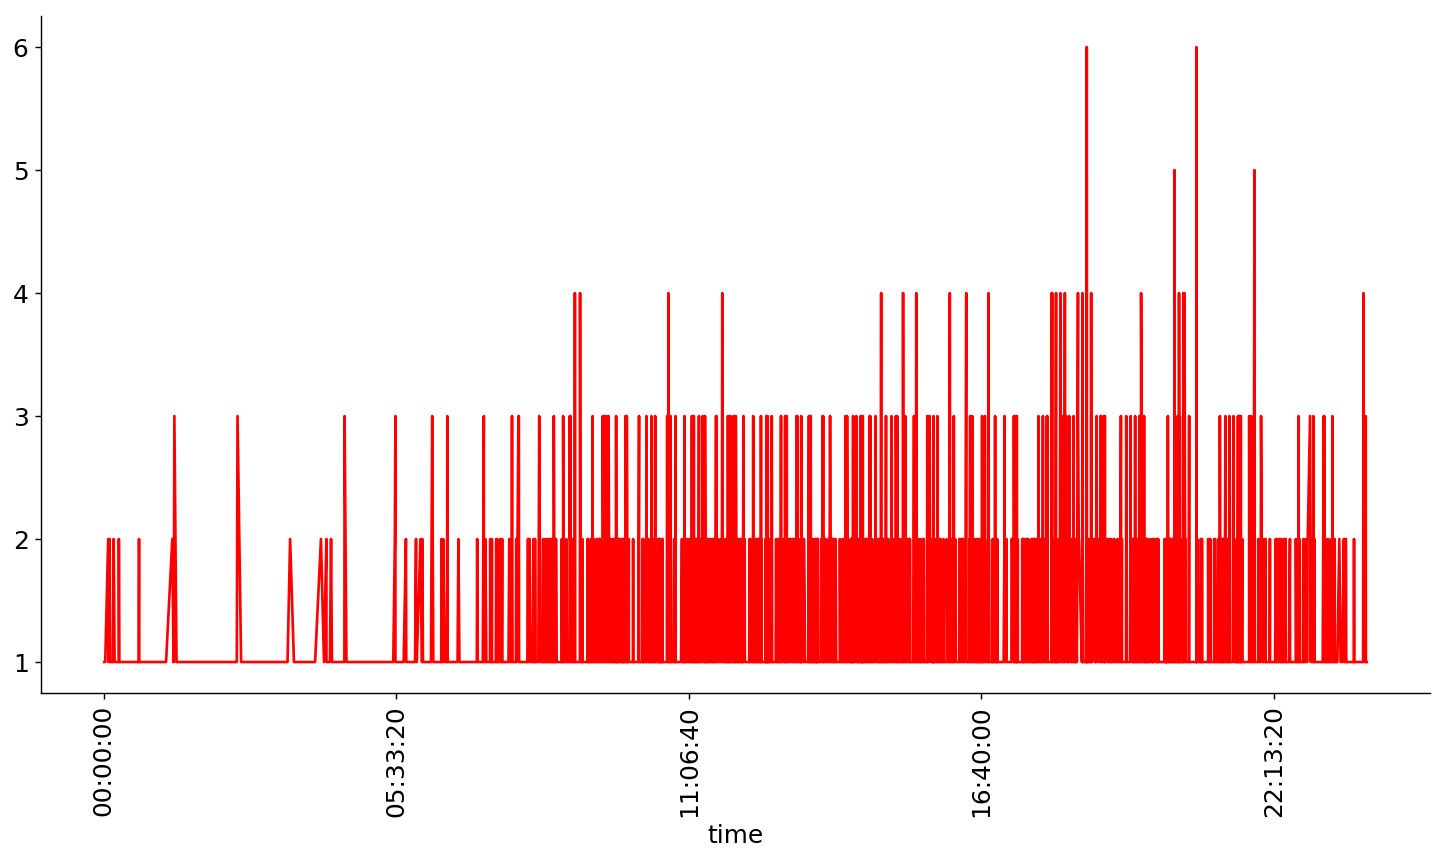

In [3]:
import random
import matplotlib.dates as mdates
import matplotlib.mlab as mlab

# generate some random data (approximately over 5 years)
data_1 = data_set[['Enquiry Status','Enquired Date']]
data_2 = data_set[['Enquiry Status','Enquired Time']]

plot_date = data_1.groupby(['Enquired Date', 'Enquiry Status']).size().reset_index(name="counts")
plot_date = plot_date.loc[plot_date['Enquiry Status'] == 'Accepted']

plot_time = data_2.groupby(['Enquired Time', 'Enquiry Status']).size().reset_index(name="counts")
plot_time = plot_time.loc[plot_time['Enquiry Status'] == 'Accepted']


plt.plot_date(x=plot_time['Enquired Time'], y=plot_time['counts'],fmt="r-")
plt.xticks(rotation=90)
plt.show()

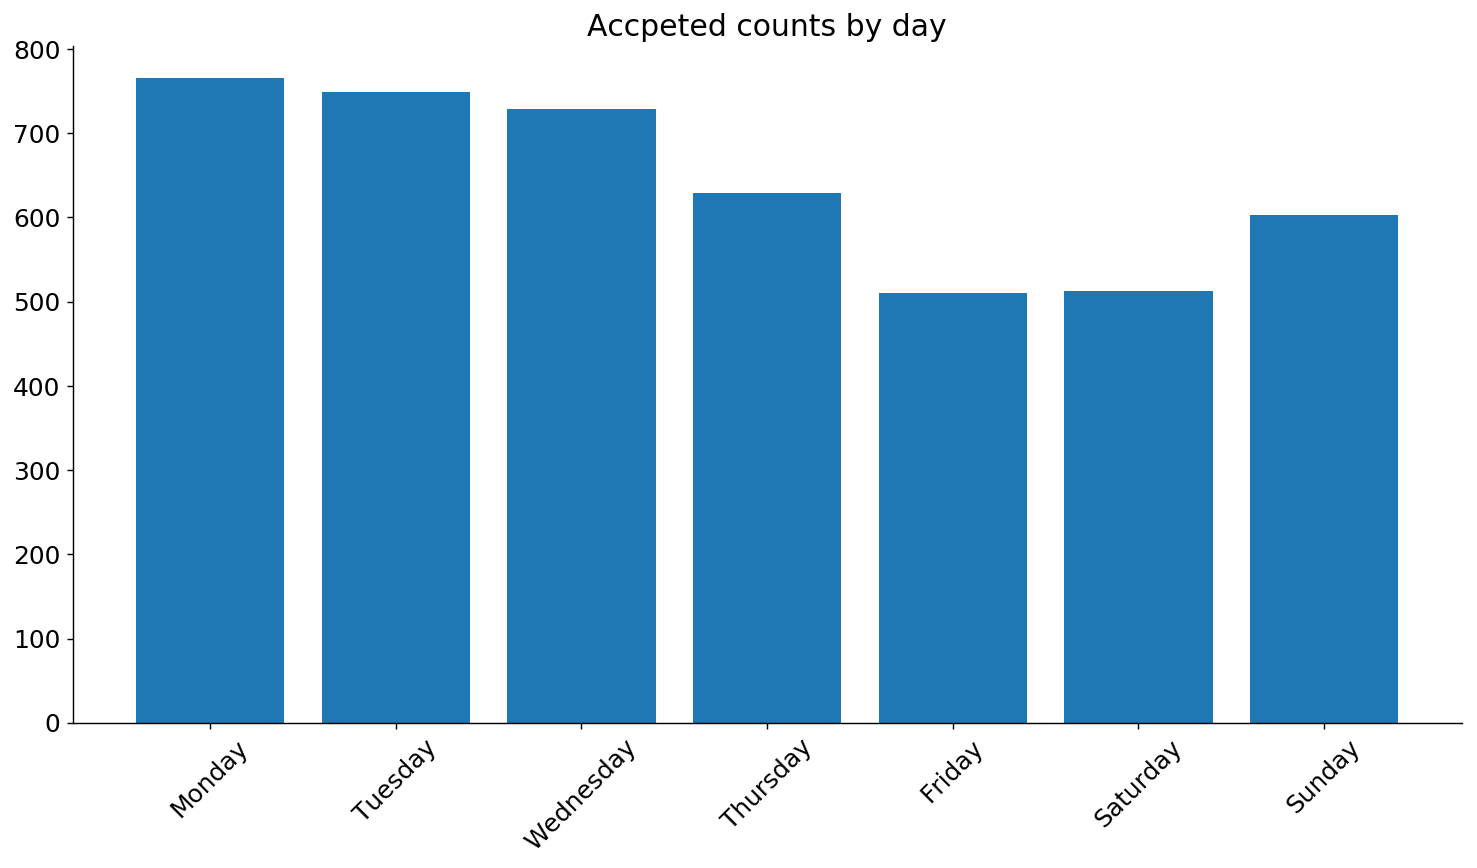

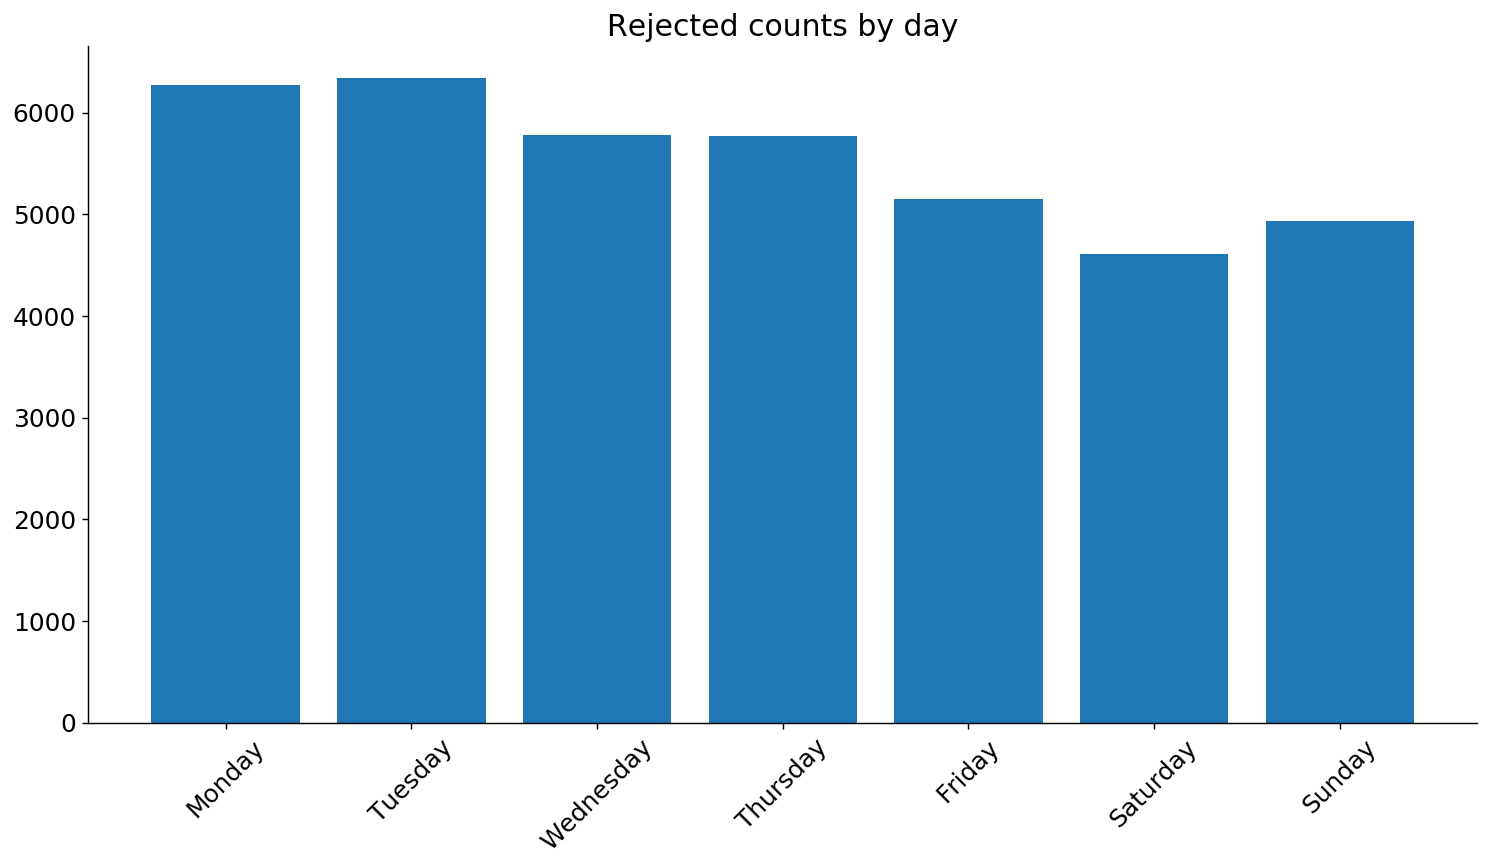

In [4]:
import calendar

plt_accepted = data_set.loc[data_set['Enquiry Status'] == 'Accepted']

# get and sort acceptances by day
count_day_accepted = plt_accepted.groupby(['day_of_week']).size().reset_index(name="counts")
weekdays = list(calendar.day_name)
mapping = {day: i for i, day in enumerate(weekdays)}
key = count_day_accepted['day_of_week'].map(mapping)
count_day_accepted = count_day_accepted.iloc[key.argsort()].reset_index(drop=True)


plt_rejected = data_set.loc[data_set['Enquiry Status'] == 'Rejected']

count_day_rejected = plt_rejected.groupby(['day_of_week']).size().reset_index(name="counts")
weekdays = list(calendar.day_name)
mapping = {day: i for i, day in enumerate(weekdays)}
key = count_day_rejected['day_of_week'].map(mapping)
count_day_rejected = count_day_rejected.iloc[key.argsort()].reset_index(drop=True)



plt_X1 = plt_accepted[['Loan Amount','day_of_week']]
plt_y1 = plt_accepted[['Enquiry Status']]

# ax = count_day.plot()
# ax.set_xlabel("Day")
# plt.plot_date(x=count_day['day_of_week'], y=count_day['counts'],fmt="r-")
# plt.plot_date(x=count_date['Enquired Date'], y=count_date['counts'],fmt="r-")

# plt.plot(count_day_accepted['day_of_week'], count_day_accepted['counts'])
# plt.xticks(rotation=45)
# plt.show()

# print(count_day_accepted['day_of_week'].shape[0])
plt.title('Accpeted counts by day')
plt.bar(range(count_day_accepted['day_of_week'].shape[0]), count_day_accepted['counts'])
plt.xticks(range(count_day_accepted['day_of_week'].shape[0]),count_day_accepted['day_of_week'].values, rotation=45)
plt.show()

plt.title('Rejected counts by day')
plt.bar(range(count_day_rejected['day_of_week'].shape[0]), count_day_rejected['counts'])
plt.xticks(range(count_day_rejected['day_of_week'].shape[0]),count_day_rejected['day_of_week'].values, rotation=45)
plt.show()

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

le = LabelEncoder()
class MultiColumnLabelEncoder:
    def __init__(self, columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self, X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = le.fit_transform(output[col])
#                 output[col] = OneHotEncoder().fit_transform(output[col])
        else:
            for colname, col in output.iteritems():
                output[colname] = le.fit_transform(col)
#                 output[colname] = OneHotEncoder().fit_transform(col)
        return output
       

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)


In [6]:
encoded_df = data_set.loc[:, data_set.columns != 'Loan Amount']
# MultiColumnLabelEncoder(columns = encoded_df.keys()).fit_transform(data_set)
# X = MultiColumnLabelEncoder(columns = encode_df.keys()).fit_transform(X)
# y = le.fit_transform(y)
data_set = MultiColumnLabelEncoder(columns = encoded_df.keys()).fit_transform(data_set)

In [7]:
# X = data_set[['Marketing Code','App Source', 'Web Source', 'Classification','Enquired Date',]]
X = data_set[data_set.keys()]
X = X.drop(['Enquiry Status'],1)
X = X.drop(['Enquired'],1)
y = data_set[target]

In [8]:
print("Keys of enquiries_dataset: \n{}".format(X.keys()))

Keys of enquiries_dataset: 
Index(['Marketing Code', 'App Source', 'Web Source', 'Classification',
       'Loan Amount', 'Enquired Date', 'Enquired Time', 'day_of_week'],
      dtype='object')


In [9]:
print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

Shape of X: (43380, 8)
Shape of y: (43380,)


In [10]:
# feature selection
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
selected_X = model.transform(X)

# Get idxs of columns to keep
idxs_selected = model.get_support(indices=True)

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                     test_size=0.3,
                     random_state=0,
                     stratify=y)
# rescale data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', C=0.1)
lr.fit(X_train_std, y_train)

print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))
print(lr.intercept_)
print(lr.coef_)

Training accuracy: 0.894816571165
Test accuracy: 0.89472875365
[-2.21063066 -7.56139885 -7.68156027  2.20703252]
[[ 0.30154383  0.36377658 -0.03274013  0.16648314  0.24631491  0.05436209
  -0.1514515   0.06102956]
 [ 0.          0.          0.          0.          0.          0.16182552
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.        ]
 [-0.29912128 -0.36243623  0.03266777 -0.1643233  -0.24414815 -0.06104907
   0.15356691 -0.05744938]]


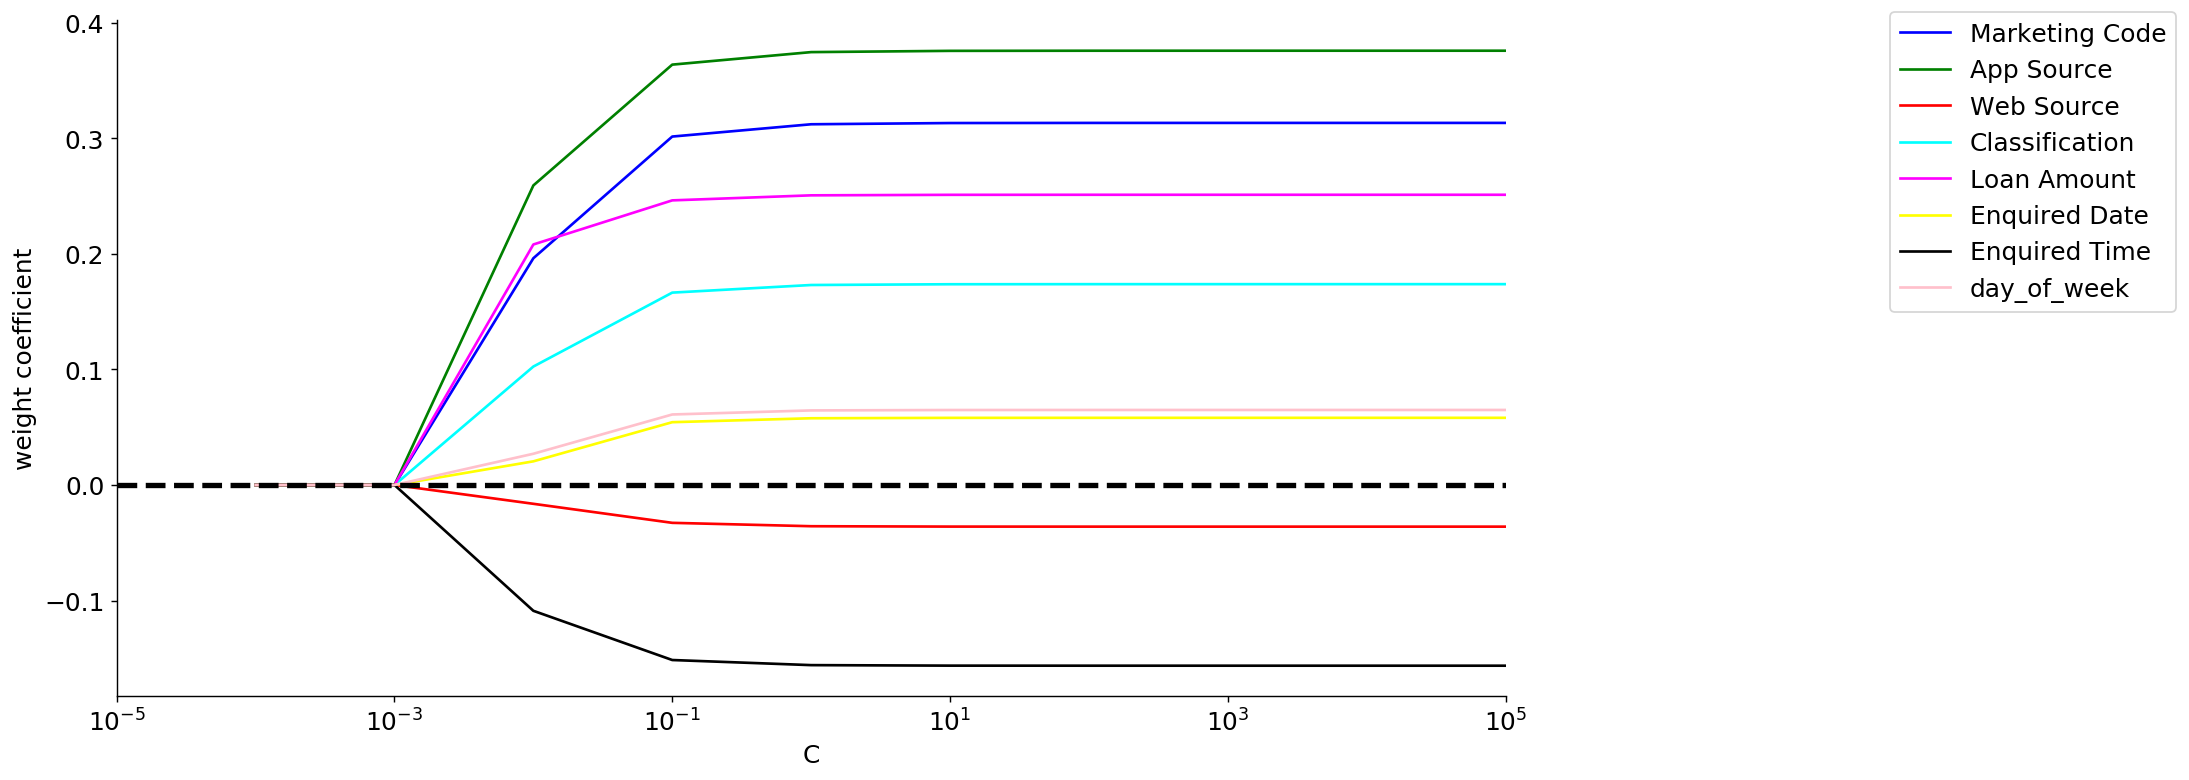

In [13]:
fig = plt.figure()
ax = plt.subplot(111)

colors = ['blue', 'green', 'red', 'cyan','magenta', 'yellow', 'black','pink', 'lightgreen', 'lightblue',
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10. ** c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[0])
    params.append(10 ** c)
    
weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=X.columns[column],
             color=color)
    
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center',
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
plt.show()

Test score: 0.90


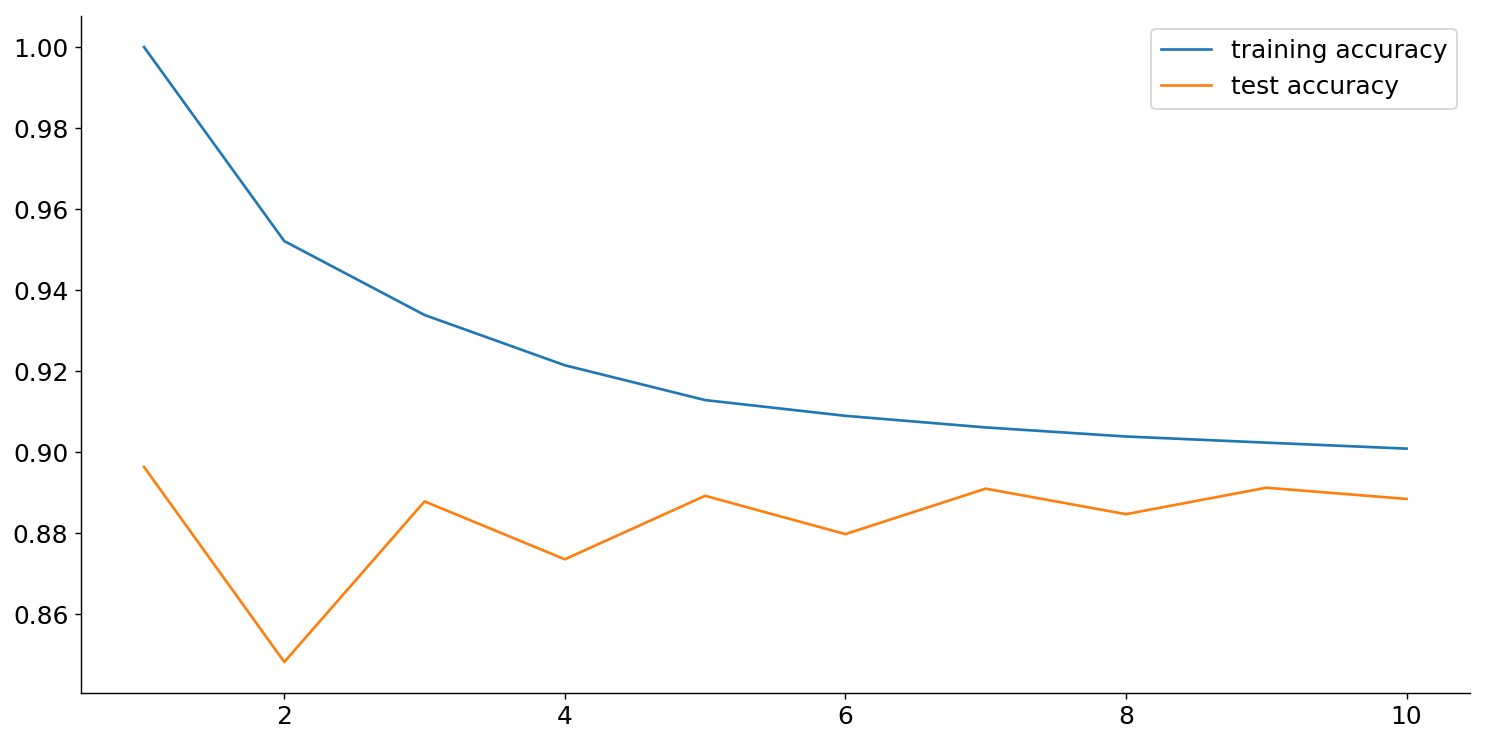

In [14]:
from sklearn.neighbors import KNeighborsClassifier

kn = KNeighborsClassifier(n_neighbors=7)
kn.fit(X_train_std, y_train)
pred_kn = kn.predict(X_test)
print("Test score: {:.2f}".format(kn.score(X_test_std, y_test)))


training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10.
neighbors_settings = range(1, 11)
for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.legend()

In [15]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss="hinge", penalty="l2")
sgd.fit(X_train_std, y_train)
pred_sgd = sgd.predict(X_test)
print("Test score: {:.2f}".format(sgd.score(X_test_std, y_test)))

Test score: 0.89


In [16]:
from sklearn.kernel_approximation import RBFSampler

rbf_feature = RBFSampler(gamma=1, random_state=1)
X_features = rbf_feature.fit_transform(X_train_std)
clf = SGDClassifier()  
clf.fit(X_train_std, y_train)
print("Test score: {:.2f}".format(clf.score(X_test_std, y_test)))

Test score: 0.89


In [17]:
from sklearn import svm
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import cross_val_score

svc = svm.SVC()
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_test)
print("Test score: {:.2f}".format(svc.score(X_test, y_test)))

scores = cross_val_score(clf, X, y, cv=5)

# N = range(1, 16)
# for n in N:
#     pca = KernelPCA(n_components=n)
#     X_n_kept = pca.fit_transform(X_test_std)
#     # Estimate accuracy on the data set with top n components
#     classifier = svm.SVC(gamma=0.001)
#     score_n_components = cross_val_score(classifier, X_n_kept, y_test).mean()
#     print('Score with the data set of top {0} components: {1:.2f}'.format(n, score_n_components))

Test score: 0.92


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics

rfc = RandomForestClassifier(n_estimators=500)
rfc.fit(X_train_std, y_train)
pred_forest = rfc.predict(X_test)

print("Test score: {:.2f}".format(rfc.score(X_test_std, y_test)))

scores = cross_val_score(rfc, X_test_std, y_test)

Test score: 0.93


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression()
lr = lr.fit(X_train_pca, y_train)
pipe_lr = make_pipeline(PCA(n_components=2),LogisticRegression(random_state=1))

# lr = LogisticRegression(penalty='l1', C=0.1, random_state=0)
# lr.fit(X_train_std, y_train)
pipe_lr.fit(X_train_std, y_train)
pred_lr = pipe_lr.predict(X_test)
# print("Test score: {:.2f}".format(pred_lr.score(X_test, y_test)))
print('Training accuracy:', pred_lr.score(X_train_std, y_train))
print('Test accuracy:', pred_lr.score(X_test_std, y_test))

AttributeError: 'numpy.ndarray' object has no attribute 'score'

In [ ]:
feat_labels = X.columns[:]
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
    
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),importances,align='center')
plt.xticks(range(X_train.shape[1]),feat_labels, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [ ]:

# count2.plot(logy=True)
# plt_X2 = plt_rejected[['Loan Amount','day_of_week']]
# plt_y2 = plt_rejected[['Enquiry Status']]
# # plt_X = X.sort_values(by=['Loan Amount'])
# # plt_X = plt_X['Loan Amount']
# # display(plt_X)

# fig, ax = plt.subplots()
# ax.yaxis.set_major_formatter(formatter)
# # ax.plot(plt_X, orig_y)
# # plt.scatter(plt_X1['day_of_week'], plt_X1['Loan Amount'],color='red', marker='o', label='Accepted')
# # plt.scatter(plt_X2['day_of_week'], plt_X2['Loan Amount'], color='blue', marker='x', label='Rejected')
# # plt.plot(plt_X1['day_of_week'], plt_y1, label='Accepted')
# # plt.plot(plt_X2['day_of_week'],plt_y2, label='Rejected')

# plt.xlabel('Day')
# plt.xticks(rotation=45)
# plt.ylabel('Loan Amount')
# plt.legend(loc='upper left')
# plt.show()

In [ ]:
count_date_accepted = plt_accepted.groupby(['Enquired Date']).size().reset_index(name="counts")
count_date_rejected = plt_rejected.groupby(['Enquired Date']).size().reset_index(name="counts")

plt.plot_date(x=count_date_accepted['Enquired Date'], y=count_date_accepted['counts'],fmt="r-")
plt.xticks(rotation=90)
plt.show()

In [ ]:
from matplotlib.ticker import FuncFormatter
def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fK' % (x*1e-4)

formatter = FuncFormatter(millions)

count_amount_accepted = plt_accepted.groupby(['Loan Amount']).size().reset_index(name="counts")
count_amount_rejected = plt_rejected.groupby(['Loan Amount']).size().reset_index(name="counts")

# count_amount_accepted.to_csv('test.csv')
# display(count_amount_accepted)
fig, ax = plt.subplots()
plt.plot(count_amount_accepted['Loan Amount'], count_amount_accepted['counts'])
plt.xticks(rotation=45)
ax.xaxis.set_major_formatter(formatter)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

print("KNeighborsClassifier:")
# tn, fp, fn, tp = confusion_matrix(y_test, pred_kn).ravel()
print(confusion_matrix(y_test, pred_kn))
# print (tn, fp, fn, tp)
print("\nSGDClassifier:")
print(confusion_matrix(y_test, pred_sgd))
print("\nSVC:")
print(confusion_matrix(y_test, pred_svc))
print("\nRandomForestClassifier")
print(confusion_matrix(y_test, pred_forest))

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

print("f1 score LogisticRegression: {:.2f}".format(f1_score(y_test, pred_lr, average='weighted')))
print("f1 score KNeighborsClassifier: {:.2f}".format(f1_score(y_test, pred_kn, average='weighted')))
print("f1 score SGDClassifier: {:.2f}".format(f1_score(y_test, pred_sgd,average='weighted')))
print("f1 score SVC: {:.2f}".format(f1_score(y_test, pred_svc,average='weighted')))
print("f1 score RandomForestClassifier: {:.2f}".format(f1_score(y_test, pred_forest,average='weighted')))
print()
print("precision score LogisticRegression: {:.2f}".format(precision_score(y_test, pred_lr, average='weighted')))
print("precision score KNeighborsClassifier: {:.2f}".format(precision_score(y_test, pred_kn, average='weighted')))
print("precision score SGDClassifier: {:.2f}".format(precision_score(y_test, pred_sgd,average='weighted')))
print("precision score SVC: {:.2f}".format(precision_score(y_test, pred_svc,average='weighted')))
print("precision score RandomForestClassifier: {:.2f}".format(precision_score(y_test, pred_forest,average='weighted')))

In [ ]:
# input_x = X.iloc[:]
# input_x_test = X.iloc[:,idxs_selected]
# # input_x = input_x.iloc[0,idxs_selected]

# # input_x = input_x.drop('Enquiry Status', 1)

# input_x_test = MultiColumnLabelEncoder(columns = input_x_test.keys()).fit_transform(input_x_test)
# input_x_test = scaler.fit_transform(input_x_test)

# # for row in input_x:
# #     result = rfc.predict(row)[0]
# #     proba = np.max(rfc.predict_proba(row))    

# #     print('reuslt: {}'.format(le.inverse_transform(result)))
# #     print('probability: {0}%'.format(proba))
# #     print()

# # result = rfc.predict(input_x)[0]
# # proba = np.max(rfc.predict_proba(input_x))    

# # print('reuslt: {}'.format(le.inverse_transform(result)))
# # print('probability: {0}%'.format(proba))
# result = rfc.predict(input_x_test)
# result = le.inverse_transform(result)
# proba = rfc.predict_proba(input_x_test)   
# proba = [np.max(p) for p in proba]
# input_x.to_csv('example.csv')

In [ ]:
# input_x = input_x.assign(predict=result.tolist())
# input_x = input_x.assign(possibility=proba)
# input_x.head()
# input_x.to_csv('result/v1.csv')